# The Scattering Transform
## Linearization of the space + linear SVM


<div align="center">
 <img src="https://raw.githubusercontent.com/giulioisac/DNN-Study/master/linearization.png" >
</div>

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage as ndi
import skimage 
from skimage.util import img_as_float
from filter_bank import multiresolution_filter_bank_morlet2d

### The Data set
Working with the MNIST dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
#reshape MNIST
MNIST_im=[]
for j,image in enumerate(mnist.train.images):
    MNIST_im.append(image.reshape(28,28))
np.shape(MNIST_im)
#average luminosity to 0
MNIST_means = np.array(MNIST_im).reshape(len(MNIST_im), -1).mean(1).astype('float32')
MNIST_im = MNIST_im - MNIST_means[:, np.newaxis, np.newaxis]
#reshape to 32*32 for power of 2
px=32
X_train = np.zeros((len(MNIST_im), px, px))
X_train[:, 3:31, 3:31] = MNIST_im
X_train = X_train.astype('float32')

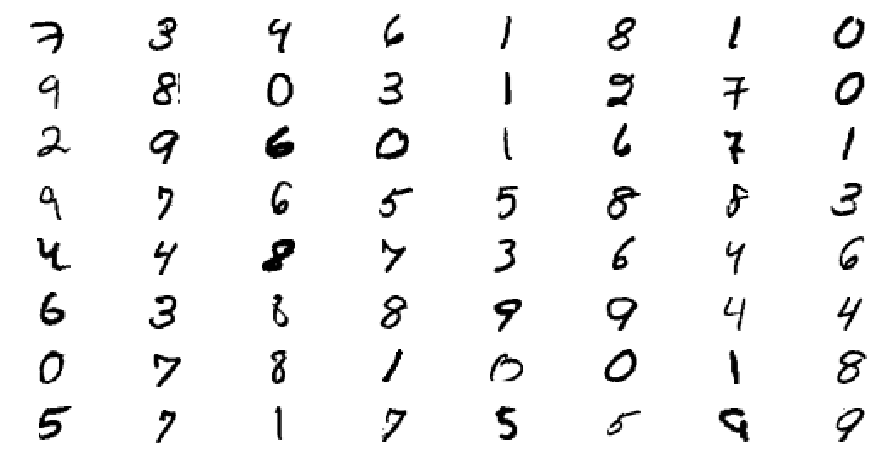

In [5]:
plt.figure(figsize=(16,8))
for j in np.arange(64):
    plt.subplot(8,8,j+1)
    plt.imshow(MNIST_im[j],interpolation='nearest',cmap=plt.get_cmap("binary"))
    plt.axis("off")

## The Wavelet Filters 
taken from [here](https://07306847857070430948.googlegroups.com/attach/19204cc059e291/gabor_vs_scattering_fortexture_classif.html?part=0.1&view=1&vt=ANaJVrH-xn9-kks1pigbDb4dLBSLLsberuGakxl8jDMIvEjmUpFfT9Z1a49xxNmn79OXYdTG_YYnJpnJmd3APa2Peqn9zALoo0I6ec9NbgyG3A23niM4rzE)

In [6]:
#Parameters of the scattering:
J=3 #number of scales
L=6 # number of angles per scale
m=2 # layers in the NN

#Parameters of the Morlet Filter
sigma_phi=0.6957
sigma_xi=0.8506

# Create filters
Filters, lw = multiresolution_filter_bank_morlet2d(px, J=J, L=L, sigma_phi=sigma_phi, sigma_xi=sigma_xi)

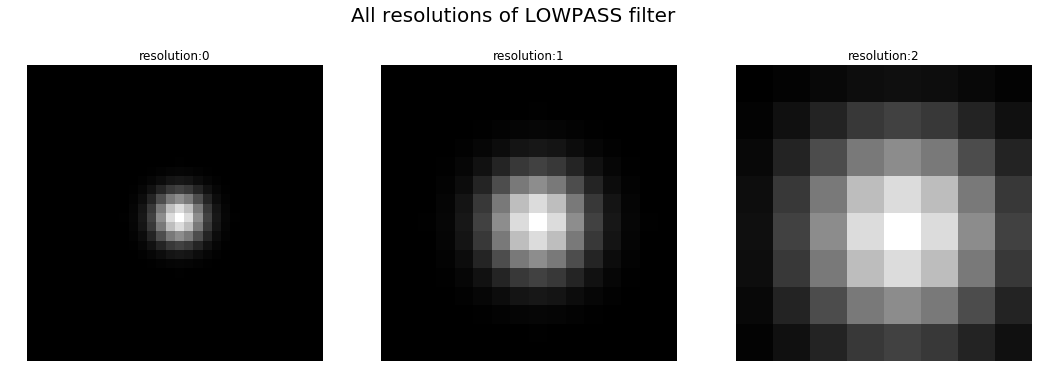

In [7]:
num_resolutions = len(Filters['psi'])
plt.figure(figsize=(18, 6))
plt.suptitle("All resolutions of LOWPASS filter", fontsize=20)
for r in np.arange(0, num_resolutions):
    plt.subplot(1, num_resolutions, r+1)
    plt.title("resolution:"+str(r))
    f=Filters['phi'][r]
    plt.imshow(np.abs(np.fft.fftshift(f)),interpolation='nearest',cmap=plt.get_cmap("gray"))
    plt.axis('off')
plt.show()

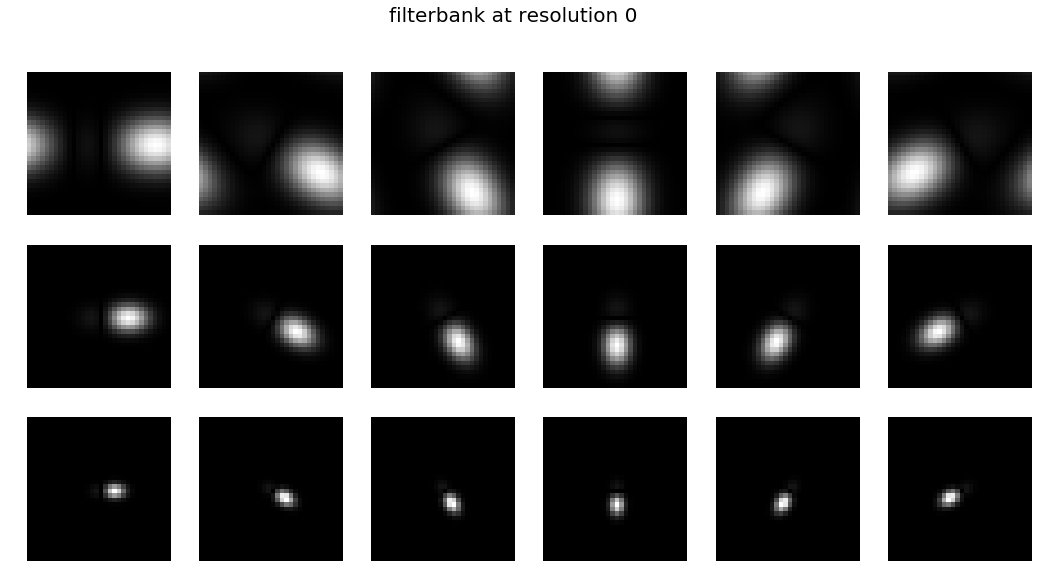

In [8]:
plt.figure(figsize=(18,9))
plt.suptitle("filterbank at resolution 0", fontsize=20)
r = 0 # resolution to check
for j in range(J):
    for l in range(L):
        f = Filters['psi'][r][j][l]
        plt.subplot(J,L,j*L+l+1)
        plt.imshow(np.abs(np.fft.fftshift(f)),interpolation='nearest',cmap=plt.get_cmap("gray")) 
        plt.axis('off')

# The Scattering Transform
<div align="center">
 <img src="https://raw.githubusercontent.com/giulioisac/DNN-Study/master/ScatteringTransform.png" >
</div>

In [20]:
def lowpass(img, phi, J, n_scat):
    img_filtered = np.real(np.fft.ifft2(np.fft.fft2(img) * phi))
    n_spatial = img.shape[-1]
    ds = int(n_spatial / n_scat)
    return 2 ** (J - 1) * img_filtered[..., ::ds, ::ds]

def fourierMult(signals, filters):
    #pointwise multplitication of filters and signal in fourier domain for all scales L
    return signals[:, np.newaxis, :, :] * filters[np.newaxis, :, :, :]
def subsample(X, j):
    #Spatial subsampling on the last two dimensions of X at a rate that
    dsf = 2 ** j
    return dsf * X[..., ::dsf, ::dsf]

In [21]:
def scattering(x, wavelet_filters=None, m=2):
    """
    Returns
    -------
    S : 4D array_like
        Scattering transform of the x signals, of size
        (N, num_coeffs, spatial_coefs, spatial_coefs). For more information
        see _[1] _[2]
    U : array_like
        Result before applying the lowpass filter and subsampling.
    S_tree : dictionary
        Dictionary that allows to access the scattering coefficients (S)
    """
    
    
    J = len(wavelet_filters['psi'][0])  # number of scales
    L = len(wavelet_filters['psi'][0][0])  # number of orientations
    num_signals = x.shape[0]
    # define number of scattering coefficients
    if m == 0:
        num_coefs = 1
    elif m == 1:
        num_coefs = 1 + J * L
    elif m == 2:
        num_coefs = int(1 + J * L + (L ** 2) * (J - 1) * J / 2)
    else:
        error_string = "Parameter m out of bounds, " \
                       "valid values are 0,1,2 not {0}"
        raise ValueError(error_string.format(m))
    
    # constants
    spatial_coefs = int(x.shape[1] / 2 ** (J - 1))
    
    # subsample at a rate a bit lower than the critical frequency
    oversample = 1
    U = []
    V = []
    v_resolution = []
    current_res = 0
    
    # vars to return (where we save the scattering and its accessing
    # tree-structure (a dictionary)
    S = np.ndarray((num_signals, num_coefs, spatial_coefs, spatial_coefs))
    # allows access to the coefficients (S) using the tree structure
    S_tree = {}
    
    ####################################################################
    # Start computing the scattering coefficients
    
    # Zero order scattering coeffs
    S[:, 0, :, :] = lowpass(x, wavelet_filters['phi'][current_res],
                                   J,  spatial_coefs)
    #store
    S_tree[0] = S[:, 0, :, :]
    l_indexing = range(0, L)
    ####################################################################
    # First order scattering coeffs
    if m > 0:
        Sm1 = S[:, 1:J * L + 1, :, :].view()
        Sm1.shape = (num_signals, J, L, spatial_coefs, spatial_coefs)
        
        # precompute the fourier transform of the images
        X = np.fft.fft2(x)
        for j in range(J):
            filtersj = wavelet_filters['psi'][current_res][j].view()
            # resolution for the next layer
            resolution = max(j - oversample, 0)
            v_resolution.append(resolution)
            # fft2(| x conv Psi_j |): X is full resolution,
            # as well as the filters
            v_j = subsample(np.fft.ifft2(fourierMult(X, filtersj)),
                             resolution)
            V.append(v_j)
            U.append(np.abs(v_j))
            filt = wavelet_filters['phi'][resolution]
            Sm1[:, j, :, :, :] = lowpass(U[j],filt, J,spatial_coefs)
            for l in range(L):
                S_tree[(j, l)] = Sm1[:, j, l, :, :]
    ######################################################################
    # Second order scattering coeffs
    if m > 1:
        sec_order_coefs = int(J * (J - 1) * L ** 2 / 2)
        S2norder = S[:, (J * L + 1):num_coefs, :, :]  # view of the data
        S2norder.shape = (num_signals, int(sec_order_coefs/L),
                          L, spatial_coefs, spatial_coefs)
        indx = 0
        for j1 in range(J):
            # U is in the spatial domain
            Uj1 = np.fft.fft2(U[j1])
            current_res = v_resolution[j1]

            for l1 in range(Uj1.shape[1]):
                # all images single angle, all spatial coefficients
                Ujl1 = Uj1[:, l1, ]

                layer1_indexing = [(j1, l1)] * L  # for S_tree

                for j2 in range(j1 + 1, J):
                    # | U_lambda1 conv Psi_lambda2 | conv phi
                    filt = wavelet_filters['psi'][current_res][j2]
                    u_j2 = np.abs(np.fft.ifft2(
                        fourierMult(Ujl1, filt)))
                    # computing all angles at once
                    S2norder[:, indx, :, :, :] = lowpass(
                                         u_j2,
                                         wavelet_filters['phi'][current_res],
                                         J, spatial_coefs)

                    # save tree structure
                    for l2 in range(L):
                        S_tree[((j1, l1), (j2, l2))] = \
                            S2norder[:, indx, l2, :, :]

                    indx = indx + 1
    return S, U, S_tree

## Computatin of Scattering Features for first and second layer of the transform (m=1,2)

In [49]:
#compute scattering coefficients:
#get a sample of images:
n_images=1000
trainIm=X_train[:n_images]
scatteringsFeatures, u, scat_tree = scattering(trainIm, Filters, m=2)

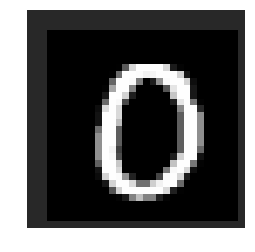

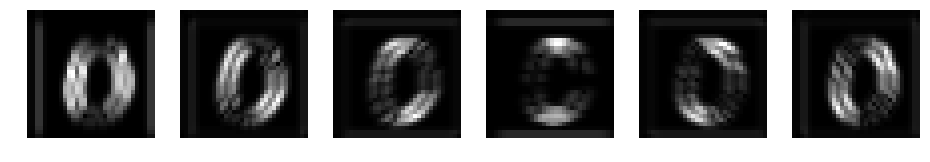

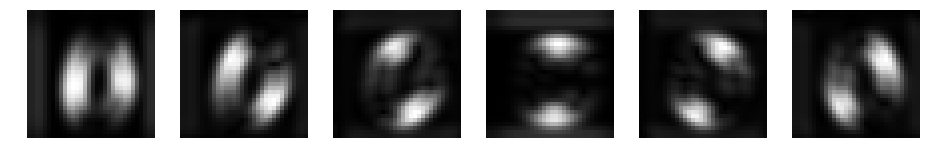

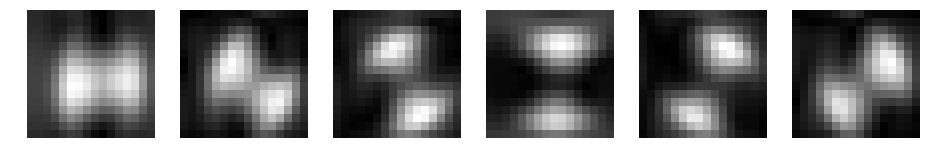

In [47]:
image=trainIm[10]
plt.figure()
plt.axis('off')
plt.imshow(image,interpolation='nearest',cmap=plt.get_cmap("gray")) 

plt.figure(figsize=(16,8))
for l in range(L):
        plt.subplot(1,L,l+1)
        plt.imshow(u[0][10][l],interpolation='nearest',cmap=plt.get_cmap("gray")) 
        plt.axis('off')
plt.figure(figsize=(16,8))
for l in range(L):
        plt.subplot(1,L,l+1)
        plt.imshow(u[1][10][l],interpolation='nearest',cmap=plt.get_cmap("gray")) 
        plt.axis('off')
plt.figure(figsize=(16,8))
for l in range(L):
        plt.subplot(1,L,l+1)
        plt.imshow(u[2][10][l],interpolation='nearest',cmap=plt.get_cmap("gray")) 
        plt.axis('off')

# Application of Linear Classifier in the transformed space

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score, KFold, ShuffleSplit

def from_features_to_classif_scores(scat_features_b,broadtz_labels):
    #stack them for learning
    scat_features_b = scat_features_b.reshape((len(scat_features_b),-1))
    # apply pipeline
    n = len(scat_features_b)
    pipeline = make_pipeline(Normalizer(),StandardScaler(),svm.SVC(kernel="linear"))
    cv = ShuffleSplit(n,n_iter=3,test_size=1, train_size=1)
    scat_scores_b = cross_val_score(pipeline,scat_features_b,broadtz_labels,cv=5,n_jobs=5)
    print('score:',scat_scores_b)

In [55]:
#relabel mnist
labels= mnist.train.labels[:n_images]
MNISTlabels=np.zeros(n_images)
for i,label in enumerate(labels):
    for j in np.arange(10):
        if(labels[i][j]==1):MNISTlabels[i]=j

In [57]:
print('Scat initial BD, input for '+str(n_images) +' image is:')
from_features_to_classif_scores(scatteringsFeatures,MNISTlabels)

Scat initial BD, input for 1000 image is:
score: [ 0.94117647  0.95544554  0.94527363  0.95431472  0.95918367]
